# Bike sharing Beispiel

In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

--- 
## 1) Laden und Interpretation des Datensatzes


In [19]:
# laden des Datensatzes
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [20]:
#Ausgabe der obersten fünf Zeilen + Kopfzeile 
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Erläuterung des Datensatzes:
- Datensatz liefert Anzahl an verliehenen Fahrrädern für jede Stunde eines Tages vom 1. Januar 2011 bis 31. Dezember 2012.
- Anzahl ist aufgeteilt in zufällig und registriert, aufsummiert in der cnt Spalte. 

>(Auszug aus README):
>	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered



### **Zielsetzung**: Ermittlung der Anzahl an ausgeliehenen Fahrrädern:


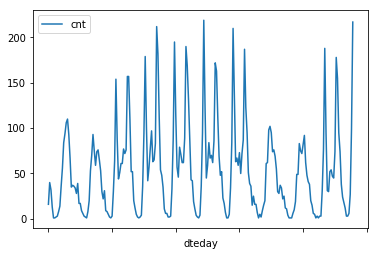

In [21]:
rides[:24*10].plot(x='dteday', y='cnt')

- **Darstellung** zeigt die stündliche Anzahl ausgeliehener Fahrräder über ca. 10 Tage. (Einige Tage haben nicht exakt 24 Einträge im Datensatz -> nicht exakt 10 Tage.)

- Datensatz ist seh kompliziert:
    - Wochenenden haben geringere Anzahl
    - Spitzen wenn Leute zur Arbeit/ nach Hause fahren.
    - Datensatz liefert Temperatur, Feuchtigkeit (en. humidity) und Windgeschwindigkeit
- Modell soll alle Eingabeparameter berücksichtigen.


---
# 2) Präparation des Datensatzes

### 2.1) Umwandlung der kategorischen Variablen in "Dummy Variablen":
- Umwandlung der kategorischen Variablen (Saison,Wetter,Monat,Stunde,Wochentag) in (binäre) dummy-Variablen 
- Sehr einfach mit pandas: get_dummies()

In [22]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    #Erzeuge binäre Dummy Variablen der kategorischen Variablen
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    # Füge neue Spalten dem Datensatz ("rides") hinzu
    rides = pd.concat([rides, dummies], axis=1)
# Lösche ursprüngliche (wahre) Werte
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### 2.2) Umskalierung (Standardisierung) der kontinuierlichen Variablen
- Unterschiedliche Daten ($\rightarrow$ unterschiedliche Skalierung) werden vergleichbar indem Standardnormalverteilung der Daten angenommen wird. Durch z-Transformation können sämtliche Normalverteilungen standardisiert werden ($\mu = 0$, $\sigma$ = 1).

- Skalierungsfaktoren werden gespeichert um Modellvorhersagen interpretieren zu können (später).


In [23]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Speichere Skalierungsfaktoren in dictionary
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
    
    # Bsp. "pandas dataframe object":  
    # (data['casual'] - 5) -> Ergebnis: Jeder Wert der casual Spalte - 5 (dtype: pandas series)    

### 2.3) Aufteilung der Daten in trainings-, test-, und validations-Datensatz
- Test-set besteht aus Einträgen der letzten 21 Tage

In [24]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]
# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

- Teile restlichen Datensatz in  trainings- und validations-Datensatz (Validation des Netzwerks nachdem es trainiert wurde) um Overfitting zu vermeiden.
- Da der Datensatz aus Zeitfolgen besteht, trainieren wir also mit vergangenenen Daten und wollen Vorhersagen zu Zukunfts-Daten treffen (validations-Datensatz).

<img src="Bilder/Overfitting.png" width=500px>

In [25]:
# Nutze ca. letzte 60 Tage der Daten als Validations set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]
print(train_features.shape)
print(val_features.shape)  # 60*40 = 1440
# Datensatz besteht aus 59 Spalten (wg. dummy-Variablen), 3 davon sind auf Anzahl bezogen(kein input). 

(15435, 56)
(1440, 56)


---
# 3) Neuronales Netz (NN)

<img src="assets/neural_network.png" width=300px>

- 2 "layer" NN. (hidden und output)
- hidden layer nutz Sigmoid - Aktivierungsfkt.  $output = sig(x) = \frac{1}{1+e^{-x}} $ 
- Output layer wird zur Regression genutzt und nutzt keine Aktivierungsfkt. (bzw. $output = input = x$)




In [41]:
import numpy as np
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Anzahl der Knoten in input, hidden und output layer.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialisiere Gewichte Normalverteilt mit MW 0, Standardabweichung = # input_nodes ^ -0.5) 
        # (1/sqrt(n)) Hält input der Sigmoid-fct gering für steigende Anzahl an inputs       
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        def sigmoid(x):
            return 1 / (1 + np.exp(-x)) 
        
        def relu(x):
            return np.tanh(x)
        
        self.activation_function = relu
                    
#########################################################
# Fkt'saufruf um Netzwerktraining zu starten
##########################################################

    def train(self, features, targets):
        ''' Trainiere Netzwerk anhand von batch aus features und labels
        
            Arguments
            ---------
            
            features: 2D array, Reihe entspricht Datensatz, Spalte entspricht feature
            targets: 1D array aus zugehörigen target/label Werten        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):            
            # forward pass
            final_outputs, hidden_outputs = self.forward_pass_train(X) 
            # backpropagation
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        '''durchlaufe forward pass durchs Netzwerk         
            Argument
            ---------
            X: features batch

        '''
        ### Forward pass ###
        # Hidden layer
        hidden_inputs = np.dot(X , self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # Output layer
        final_inputs = np.dot(hidden_outputs , self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        '''berechne Änderung der Gewichte        
            Argumente
            ---------
            final_outputs: output des forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: Änderung der Gewichte input- zu hidden-Layer
            delta_weights_h_o: Änderung der Gewichte hidden- zu output-Layer

        '''

        # "Output error"
        # Output layer error ist Differenz zwischen Soll- und Ist- Vorhersage (en. prediction).
        error = y - final_outputs 
        
        # "Backpropagated error term" 
        # -> Ableitung des Fehlers nach Aktivierungsfkt., hier gleich error, da Aktivierungsfkt. f(x) = x 
        output_error_term = error
        
        # Anteil des Hidden-layer error
        hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
        
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        # delta_weights_i_h ist Mittelung des batches ! -> * (1 / batch_size) bei Update 
        delta_weights_i_h += hidden_error_term * X[:, None]
        
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        # update hidden-to-output weights mit gradient descent step
        self.weights_hidden_to_output += self.lr * delta_weights_h_o/n_records
        # update input-to-hidden weights mit gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records 

    def run(self, features):
        ''' durchlaufe forward pass durchs Netzwerk  
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
       
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

#########################################################
# Parameter
##########################################################
iterations = 1000
learning_rate = 0.1
hidden_nodes = 28
output_nodes = 1

---
# 3) Training


In [42]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [43]:
import sys

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size = 128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.500 ... Validation loss: 0.828

---
# 3) Überprüfe Model anhand test-set

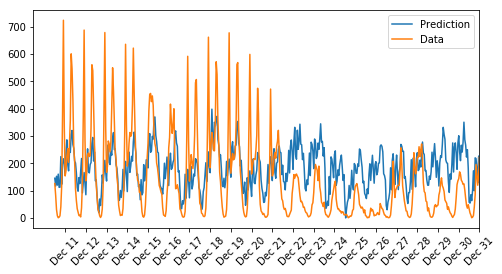

In [44]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)